<a href="https://colab.research.google.com/github/kazarach/UAS_ML/blob/main/TransferLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [26]:
mean = np.array([0.5, 0.5, 0.5])
std = np.array([0.25, 0.25, 0.25])

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
}

In [27]:
data_dir = '/content/gdrive/MyDrive/UAS ML/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=0)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(class_names)

['ants', 'bees']


In [28]:
def imshow(inp, title):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.title(title)
    plt.show()

In [29]:
inputs, classes = next(iter(dataloaders['train']))

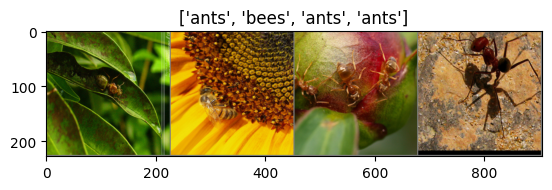

In [30]:
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [31]:
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features

model.fc = nn.Linear(num_ftrs, 2)

model = model.to(device)

criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(), lr=0.001)

In [32]:
step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

model = train_model(model, criterion, optimizer, step_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6354 Acc: 0.6230
val Loss: 0.4517 Acc: 0.8301

Epoch 1/24
----------
train Loss: 0.4839 Acc: 0.7951
val Loss: 0.3473 Acc: 0.8824

Epoch 2/24
----------
train Loss: 0.4814 Acc: 0.7746
val Loss: 0.2868 Acc: 0.9150

Epoch 3/24
----------
train Loss: 0.3906 Acc: 0.8361
val Loss: 0.2632 Acc: 0.9216

Epoch 4/24
----------
train Loss: 0.4025 Acc: 0.8197
val Loss: 0.2445 Acc: 0.9281

Epoch 5/24
----------
train Loss: 0.3892 Acc: 0.8443
val Loss: 0.2304 Acc: 0.9412

Epoch 6/24
----------
train Loss: 0.4192 Acc: 0.8115
val Loss: 0.2276 Acc: 0.9281

Epoch 7/24
----------
train Loss: 0.3560 Acc: 0.8607
val Loss: 0.2189 Acc: 0.9346

Epoch 8/24
----------
train Loss: 0.3523 Acc: 0.8525
val Loss: 0.2259 Acc: 0.9346

Epoch 9/24
----------
train Loss: 0.3496 Acc: 0.8443
val Loss: 0.2315 Acc: 0.9281

Epoch 10/24
----------
train Loss: 0.3387 Acc: 0.8443
val Loss: 0.2257 Acc: 0.9477

Epoch 11/24
----------
train Loss: 0.3335 Acc: 0.8607
val Loss: 0.2275 Acc: 0.9412

Ep

In [33]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

In [34]:
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

In [35]:
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5725 Acc: 0.6885
val Loss: 0.1941 Acc: 0.9412

Epoch 1/24
----------
train Loss: 0.5282 Acc: 0.7213
val Loss: 0.2020 Acc: 0.9216

Epoch 2/24
----------
train Loss: 0.5331 Acc: 0.7746
val Loss: 0.4416 Acc: 0.8170

Epoch 3/24
----------
train Loss: 0.6721 Acc: 0.7008
val Loss: 0.1978 Acc: 0.9412

Epoch 4/24
----------
train Loss: 0.5390 Acc: 0.7828
val Loss: 0.3776 Acc: 0.8562

Epoch 5/24
----------
train Loss: 0.5177 Acc: 0.7664
val Loss: 0.1956 Acc: 0.9477

Epoch 6/24
----------
train Loss: 0.5220 Acc: 0.7787
val Loss: 0.2209 Acc: 0.9346

Epoch 7/24
----------
train Loss: 0.2743 Acc: 0.8934
val Loss: 0.1922 Acc: 0.9281

Epoch 8/24
----------
train Loss: 0.3846 Acc: 0.8156
val Loss: 0.1665 Acc: 0.9346

Epoch 9/24
----------
train Loss: 0.3531 Acc: 0.8566
val Loss: 0.1678 Acc: 0.9412

Epoch 10/24
----------
train Loss: 0.4011 Acc: 0.8074
val Loss: 0.1954 Acc: 0.9346

Epoch 11/24
----------
train Loss: 0.3838 Acc: 0.8156
val Loss: 0.1774 Acc: 0.9346

Ep